In [1]:
#Import necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Import Online Retail Data containing transactions from 01/12/2010 and 09/12/2011
Rtl_data = pd.read_excel('Online Retail.xlsx', encoding = 'unicode_escape')
Rtl_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
#Check the shape (number of columns and rows) in the dataset
Rtl_data.shape

(541909, 8)

In [4]:
Rtl_data["Country"].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [5]:
#Customer distribution by country
country_cust_data=Rtl_data[['Country','CustomerID']].drop_duplicates()
country_cust_data.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


In [6]:
Rtl_data=Rtl_data[Rtl_data["Country"]=="United Kingdom"].reset_index(drop=True)

In [7]:
Rtl_data["Country"].unique()

array(['United Kingdom'], dtype=object)

In [8]:
#Check for missing values in the dataset
Rtl_data.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

In [9]:
#Remove missing values from CustomerID column, can ignore missing values in description column
Rtl_data = Rtl_data[pd.notnull(Rtl_data['CustomerID'])]

#Validate if there are any negative values in Quantity column
Rtl_data.Quantity.min()

-80995

In [10]:
#Validate if there are any negative values in UnitPrice column
Rtl_data.UnitPrice.min()

0.0

In [11]:
#Filter out records with negative values
Rtl_data = Rtl_data[(Rtl_data['Quantity']>0)]

In [12]:
Rtl_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354345 entries, 0 to 495477
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354345 non-null  object        
 1   StockCode    354345 non-null  object        
 2   Description  354345 non-null  object        
 3   Quantity     354345 non-null  int64         
 4   InvoiceDate  354345 non-null  datetime64[ns]
 5   UnitPrice    354345 non-null  float64       
 6   CustomerID   354345 non-null  float64       
 7   Country      354345 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.3+ MB


In [13]:
#Convert the string date field to datetime
Rtl_data['InvoiceDate'] = pd.to_datetime(Rtl_data['InvoiceDate'])

In [14]:
#Add new column depicting total amount
Rtl_data['TotalAmount'] = Rtl_data['Quantity'] * Rtl_data['UnitPrice']

In [15]:
#Check the shape (number of columns and rows) in the dataset after data is cleaned
Rtl_data.shape

(354345, 9)

In [16]:
Rtl_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## RFM Modelling

In [17]:
#Recency = Latest Date - Last Inovice Data, Frequency = count of invoice no. of transaction(s), Monetary = Sum of Total 
#Amount for each customer
import datetime as dt

#Set Latest date 2011-12-10 as last invoice date was 2011-12-09. This is to calculate the number of days from recent purchase
Latest_Date = dt.datetime(2011,12,10)

#Create RFM Modelling scores for each customer
RFMScores = Rtl_data.groupby('CustomerID').aggregate({'InvoiceDate': lambda x: (Latest_Date - x.max()).days, 'InvoiceNo': lambda x: len(pd.Series.unique(x)), 'TotalAmount': lambda x: x.sum()})

#Convert Invoice Date into type int
#RFMScores['InvoiceDate'] = RFMScores['InvoiceDate'].astype(int)

In [18]:
RFMScores

,InvoiceDate,InvoiceNo,TotalAmount
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,11,4196.01
12748.0,0,210,33719.73
12749.0,3,5,4090.88
12820.0,3,4,942.34
...,...,...,...
18280.0,277,1,180.60
18281.0,180,1,80.82
18282.0,7,2,178.05


In [19]:
#Convert Invoice Date into type int
RFMScores['InvoiceDate'] = RFMScores['InvoiceDate'].astype(int)

#Rename column names to Recency, Frequency and Monetary
RFMScores.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'TotalAmount': 'Monetary'}, inplace=True)

RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,11,4196.01
2,12748.0,0,210,33719.73
3,12749.0,3,5,4090.88
4,12820.0,3,4,942.34


In [20]:
#Descriptive Statistics (Recency)
RFMScores["Recency"].describe()

count    3921.000000
mean       91.722265
std        99.528532
min         0.000000
25%        17.000000
50%        50.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

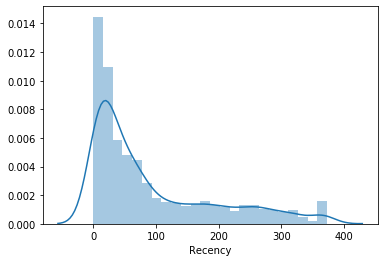

In [21]:
#Recency distribution plot
import seaborn as sns
x = RFMScores['Recency']

ax = sns.distplot(x)

In [22]:
#Descriptive Statistics (Frequency)
RFMScores.Frequency.describe()

count    3921.000000
mean        4.246111
std         7.205750
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       210.000000
Name: Frequency, dtype: float64

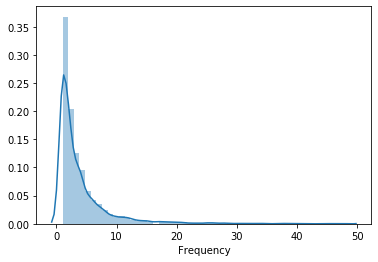

In [23]:
#Frequency distribution plot, taking observations which have frequency less than 1000
import seaborn as sns
x=RFMScores[RFMScores["Frequency"]<50]["Frequency"]
# 
# x = RFMScores.query('Frequency < 50')['Frequency']

ax = sns.distplot(x)

In [24]:
#Descriptive Statistics (Monetary)
RFMScores.Monetary.describe()

count      3921.000000
mean       1863.910113
std        7481.922217
min           0.000000
25%         300.040000
50%         651.820000
75%        1575.890000
max      259657.300000
Name: Monetary, dtype: float64

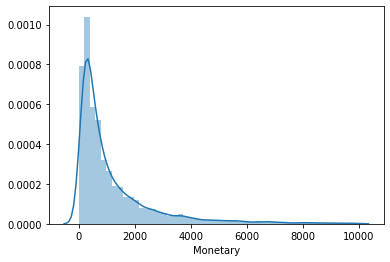

In [25]:
#Monateray distribution plot, taking observations which have monetary value less than 10000
import seaborn as sns
x=RFMScores[RFMScores["Monetary"]<10000]["Monetary"]

ax = sns.distplot(x)

In [26]:
RFMScores["Recency"].quantile(q=[0.5])

0.5    50.0
Name: Recency, dtype: float64

In [27]:
#Split into four segments using quantiles
quantiles = RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [28]:
quantiles

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 300.03999999999996, 0.5: 651.8199999999999, 0.75: 1575.89}}

In [29]:
quantiles['Frequency'][0.25]

1.0

In [30]:
#Functions to create R, F and M segments
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [31]:
#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, p='Recency',d=quantiles)
RFMScores['F'] = RFMScores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12747.0,2,11,4196.01,1,1,1
12748.0,0,210,33719.73,1,1,1
12749.0,3,5,4090.88,1,2,1
12820.0,3,4,942.34,1,2,2


In [32]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9
12747.0,2,11,4196.01,1,1,1,111,3
12748.0,0,210,33719.73,1,1,1,111,3
12749.0,3,5,4090.88,1,2,1,121,4
12820.0,3,4,942.34,1,2,2,122,5


In [33]:
#Assign Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(RFMScores.RFMScore, q = 4, labels = Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values
RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12346.0,325,1,77183.60,4,4,1,441,9,Silver
1,12747.0,2,11,4196.01,1,1,1,111,3,Platinum
2,12748.0,0,210,33719.73,1,1,1,111,3,Platinum
3,12749.0,3,5,4090.88,1,2,1,121,4,Platinum
4,12820.0,3,4,942.34,1,2,2,122,5,Platinum


In [34]:
#Validate the data for RFMGroup = 111
RFMScores[RFMScores['RFMGroup']=='111'].sort_values('Monetary', ascending=False).reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,18102.0,0,60,259657.30,1,1,1,111,3,Platinum
1,17450.0,8,46,194550.79,1,1,1,111,3,Platinum
2,17511.0,2,31,91062.38,1,1,1,111,3,Platinum
3,16684.0,4,28,66653.56,1,1,1,111,3,Platinum
4,14096.0,4,17,65164.79,1,1,1,111,3,Platinum
5,13694.0,3,50,65039.62,1,1,1,111,3,Platinum
6,15311.0,0,91,60767.90,1,1,1,111,3,Platinum
7,13089.0,2,97,58825.83,1,1,1,111,3,Platinum
8,17949.0,1,45,58510.48,1,1,1,111,3,Platinum
9,15769.0,7,26,56252.72,1,1,1,111,3,Platinum


## K-Means Clustering

In [35]:
# #Handle negative and zero values so as to handle infinite numbers during log transformation
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
#Apply handle_neg_n_zero function to Recency and Monetary columns 
RFMScores['Recency'] = [handle_neg_n_zero(x) for x in RFMScores.Recency]
RFMScores['Monetary'] = [handle_neg_n_zero(x) for x in RFMScores.Monetary]

#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = RFMScores[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

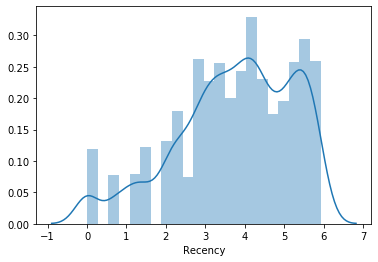

In [36]:
#Data distribution after data normalization for Recency
Recency_Plot = Log_Tfd_Data['Recency']
ax = sns.distplot(Recency_Plot)

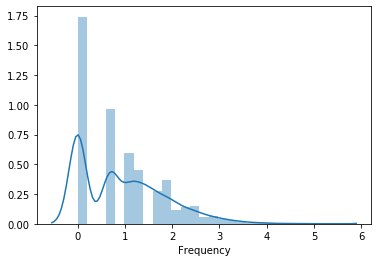

In [37]:
#Data distribution after data normalization for Frequency
Frequency_Plot = Log_Tfd_Data.query('Frequency < 1000')['Frequency']
ax = sns.distplot(Frequency_Plot)

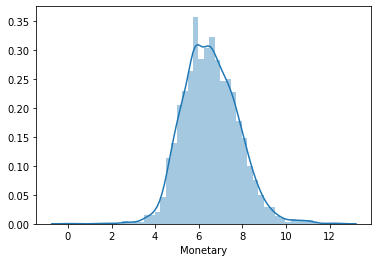

In [38]:
#Data distribution after data normalization for Monetary
Monetary_Plot = Log_Tfd_Data.query('Monetary < 10000')['Monetary']
ax = sns.distplot(Monetary_Plot)

In [39]:
from sklearn.preprocessing import StandardScaler

#Bring the data on same scale
scaler = StandardScaler()
Scaled_Data = scaler.fit_transform(Log_Tfd_Data)

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = RFMScores.index, columns = Log_Tfd_Data.columns)

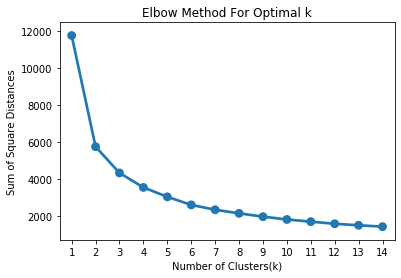

In [40]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [41]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

#Find the clusters for the observation given in the dataset
RFMScores['Cluster'] = KMean_clust.labels_
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster
CustomerID,,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9,Silver,0
12747.0,2,11,4196.01,1,1,1,111,3,Platinum,2
12748.0,1,210,33719.73,1,1,1,111,3,Platinum,2
12749.0,3,5,4090.88,1,2,1,121,4,Platinum,2
12820.0,3,4,942.34,1,2,2,122,5,Platinum,2


In [42]:
KMean_clust.labels_

array([0, 2, 2, ..., 0, 2, 0])

In [43]:
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster
CustomerID,,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9,Silver,0
12747.0,2,11,4196.01,1,1,1,111,3,Platinum,2
12748.0,1,210,33719.73,1,1,1,111,3,Platinum,2
12749.0,3,5,4090.88,1,2,1,121,4,Platinum,2
12820.0,3,4,942.34,1,2,2,122,5,Platinum,2
